## LOBSTER-ECOL GLORYs Surface and Bottom Temperature Processing

Processing zonal timeseries of surface and bottom temperatures from the GLORYs ocean reanalysis product.

**This notebook also serves as the preparation step for the surface and bottom only datasets in GLORYS_surfbot_temps/**

In [4]:

####  Libraries  ####
import xarray as xr
import dask
import os
import numpy as np
import geopandas as gpd
import regionmask
import re

# Paths to resources
box_path = "/Users/adamkemberling/Library/CloudStorage/Box-Box/"
lobecol_path = f"{box_path}Mills Lab/Projects/Lobster ECOL/Spatial_Defs/"
glorys_path = f"{box_path}RES_Data/GLORYs/NE_Shelf_TempSal/"

# daily data, surface-bottom
surfbot_path = "../GLORYS_surfbot_temps/"
surfbot_box_path = f"{glorys_path}NE_Shelf_Surfbot_Daily/"
fpaths_glorys = os.listdir(surfbot_path)


# File paths, no ds_store
# Pattern matching for .nc only
pattern = r".*\.nc$"  # Match all files ending with ".nc"

# list the .nc files
fpaths_glorys = []
for filename in os.listdir(surfbot_path):
    if re.search(pattern, filename):
        #fpaths_glorys.append(f"{glorys_path}{filename}")
        fpaths_glorys.append(f"{surfbot_path}{filename}")

# Check files are there
#fpaths_glorys[0:6]
surfbot_ds = xr.open_mfdataset(fpaths_glorys)
surfbot_ds

<xarray.Dataset> Size: 13GB
Dimensions:       (time: 11681, latitude: 132, longitude: 226)
Coordinates:
  * time          (time) datetime64[ns] 93kB 1993-01-01 ... 2024-12-24
  * latitude      (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude     (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
Data variables:
    bottom_temp   (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    bottom_depth  (time, latitude, longitude) float32 1GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    surface_temp  (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    surface_sal   (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    bottom_sal    (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>

# Cropping to the Inshore Areas, Reshape as Timeseries

From here we can loop through the inshore areas and mask out their values. The following function will perform regional masking of an xarray dataset for a target variable, returning a pandas dataframe.

<Axes: >

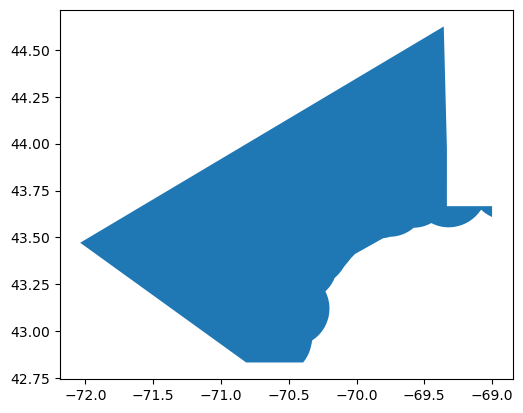

In [13]:
# Load Shapefiles into Lists

# Load Inshore masks
inshore_path = f"{lobecol_path}inshore_areas/"
inshore_areas = os.listdir(inshore_path)
inshore_names = []
inshore_polys = []
for area in inshore_areas:
    inshore_names.append(area.removesuffix(".geojson"))
    inshore_polys.append(gpd.read_file(f"{inshore_path}{area}"))


# Load offshore areas
offshore_path = f"{lobecol_path}offshore_areas/"
offshore_areas = os.listdir(offshore_path)
offshore_names = []
offshore_polys = []
for area in offshore_areas:
    offshore_names.append(area.removesuffix(".geojson"))
    offshore_polys.append(gpd.read_file(f"{offshore_path}{area}"))


# Convert lists to dictionary
inshore_poly_dict = {inshore_names[i]: inshore_polys[i] for i in range(len(inshore_names))}
offshore_poly_dict = {offshore_names[i]: offshore_polys[i] for i in range(len(offshore_names))}
    

# Plot inshore
inshore_poly_dict["513-Western_Maine"].plot()

# # Plot Offshore
# offshore_poly_dict["SNE"].plot()

In [14]:
# Function to mask
def calc_ts_mask(grid_obj, shp_obj, shp_name, var_name = "sst"):
  """
  Return a timeseries using data that falls within shapefile. 
  
  Standard deviation
  not included so that this function can be used for any period of time.
  
  Args:
    grid_obj       : xr.Dataset of the desired input data to mask
    shp_obj        : shapefile polygon to use as a mask
    shp_name (str) : String to use as name when making mask
    var_name (str) : Optional string identifying the variable to use
    climatology (bool): Whether you are masking a climatology, informs naming conventions and
    whether to process standard deviation
  """

  #### 1. Make the mask
  area_mask = regionmask.Regions(
    shp_obj.geometry,
    name = shp_name)

  #### 2. Mask the array with gom_mask to get nan test
  # mask = area_mask.mask(grid_obj, lon_name = "longitude", lat_name = "latitude")
  mask = area_mask.mask(grid_obj["longitude"], grid_obj["latitude"])

  #### 3. Extract data that falls within the mask
  masked_ds = grid_obj.where(~np.isnan(mask))

  #### 4. Calculate timeseries mean

  # Not area-weighted
  masked_ts = getattr(masked_ds, var_name).mean(dim = ("latitude", "longitude"))

  #### 5. Change time index rownames to a column 

  # Convert to Timeseries Dataframe
  masked_ts_df = masked_ts.to_dataframe()
  masked_ts_df = masked_ts_df.reset_index()[["time", f"{var_name}"]]
    
  # Return the table as output
  return masked_ts_df

## Perform Masking on Inshore/Offshore Areas

The following code will loop through the regions and process regional means of surface and bottom temperatures.

In [15]:
surfbot_ds

<xarray.Dataset> Size: 13GB
Dimensions:       (time: 11681, latitude: 132, longitude: 226)
Coordinates:
  * time          (time) datetime64[ns] 93kB 1993-01-01 ... 2024-12-24
  * latitude      (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude     (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
Data variables:
    bottom_temp   (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    bottom_depth  (time, latitude, longitude) float32 1GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    surface_temp  (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    surface_sal   (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    bottom_sal    (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>

## Loop over areas of interest:

This could definitely be sped up. A good improvement would be to adjust the calc_ts_mask() function to accept many variables. Then we could apply it once instead of four times.

In [17]:
# list to store the inshore region timeseries
inshore_ts = []  # Inshore area timeseries

# Iterate through names and shapes simultaneously
for mask_shp, mask_name in zip(inshore_polys, inshore_names):
    
    #### 1. Get masked Timeseries of surface temperature
    masked_sst = calc_ts_mask(
        grid_obj = surfbot_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "surface_temp")

    #### 2. Get masked Timeseries of bottom temperature
    masked_bt = calc_ts_mask(
        grid_obj = surfbot_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "bottom_temp")

    #### 3. surface salinity
    masked_ss = calc_ts_mask(
        grid_obj = surfbot_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "surface_sal")

    #### 4. Bottom salinity
    masked_bs = calc_ts_mask(
        grid_obj = surfbot_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "bottom_sal")
    
    #### 3. Merge on time
    
    # Merge
    regional_timeline = masked_sst.merge(masked_bt, how = "left", on = "time").merge(masked_ss, how = "left", on = "time").merge(masked_bs, how = "left", on = "time")

    #Set index as the date, drop time
    regional_timeline.index = regional_timeline.index = regional_timeline["time"]
    regional_timeline       = regional_timeline.drop(["time"], axis = 1)

    # Reset Index
    regional_timeline = regional_timeline.reset_index()
    
    # Add to list
    inshore_ts.append(regional_timeline)
    
    print(f"{mask_name} timeseries processed.")

513-Western_Maine timeseries processed.
513-Western_Maine timeseries processed.


611-Long_Island_Sound timeseries processed.
611-Long_Island_Sound timeseries processed.


612-Cholera_Bank timeseries processed.
612-Cholera_Bank timeseries processed.


537-Off_No_Mans_Land timeseries processed.
537-Off_No_Mans_Land timeseries processed.


512-Central_Maine timeseries processed.
512-Central_Maine timeseries processed.


539-Rhode_Island_Shore timeseries processed.
539-Rhode_Island_Shore timeseries processed.


625-No_Carolina_Shore timeseries processed.
625-No_Carolina_Shore timeseries processed.


614-New_Jersey_Shore timeseries processed.
614-New_Jersey_Shore timeseries processed.


621-Five_Fathom_Bank timeseries processed.
621-Five_Fathom_Bank timeseries processed.


511-Eastern_Maine timeseries processed.
511-Eastern_Maine timeseries processed.


526-Nantucket_Shoals timeseries processed.
526-Nantucket_Shoals timeseries processed.


538-Southern_Mass timeseries processed.
538-Southern_Mass timeseries processed.


615-Barnegat_Ridge timeseries processed.
615-Barnegat_Ridge timeseries processed.


613-Off_Long_Island timeseries processed.
613-Off_Long_Island timeseries processed.


514-Eastern_Mass timeseries processed.
514-Eastern_Mass timeseries processed.


625-Virginia_Shore timeseries processed.
625-Virginia_Shore timeseries processed.


521-W_South_Channel timeseries processed.
521-W_South_Channel timeseries processed.


In [18]:
# Check one
print(inshore_names[3])
inshore_ts[3].tail()

537-Off_No_Mans_Land
537-Off_No_Mans_Land


,time,surface_temp,bottom_temp,surface_sal,bottom_sal
11676,2024-12-20,8.806950,8.990282,32.504768,32.552213
11677,2024-12-21,8.227740,8.348218,32.524853,32.545542
11678,2024-12-22,7.660981,7.761496,32.513213,32.526805
11679,2024-12-23,6.773940,6.880042,32.501077,32.515059
11680,2024-12-24,6.777330,6.826165,32.525350,32.536173


<Axes: xlabel='time'>

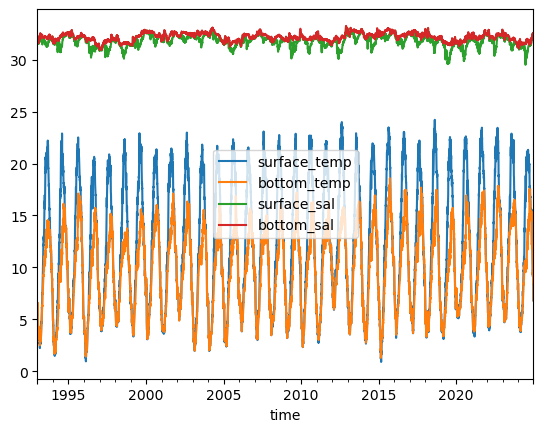

In [19]:
inshore_ts[3].plot("time")

## Process Offshore Regions

Do the same thing for the two broader offshore areas: Gulf of Maine + Georges Bank, & Southern New England

In [20]:
# list to store the inshore region timeseries
offshore_ts = []  # Inshore area timeseries

# Iterate through names and shapes simultaneously
for mask_shp, mask_name in zip(offshore_polys, offshore_names):
    
    #### 1. Get masked Timeseries of surface temperature
    masked_sst = calc_ts_mask(
        grid_obj = surface_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "surface_temp")

    #### 2. Get masked Timeseries of bottom temperature
    masked_bt = calc_ts_mask(
        grid_obj = bottom_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "bottom_temp")
    
    
    #### 3. surface salinity
    masked_ss = calc_ts_mask(
        grid_obj = surface_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "surface_sal")

    #### 4. Bottom salinity
    masked_bs = calc_ts_mask(
        grid_obj = bottom_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "bottom_sal")
    
    #### 3. Merge on time
    
    # Merge
    regional_timeline = masked_sst.merge(masked_bt, how = "left", on = "time").merge(masked_ss, how = "left", on = "time").merge(masked_bs, how = "left", on = "time")


    #Set index as the date, drop time
    regional_timeline.index = regional_timeline.index = regional_timeline["time"]
    regional_timeline       = regional_timeline.drop(["time"], axis = 1)

    # # Reset Index
    regional_timeline = regional_timeline.reset_index()
    
    # Add to list
    offshore_ts.append(regional_timeline)
    
    print(f"{mask_name} timeseries processed.")

GOM_GBK timeseries processed.
GOM_GBK timeseries processed.


SNE timeseries processed.
SNE timeseries processed.


In [21]:
# Check one
print(offshore_names[0])
offshore_ts[0].head()

GOM_GBK
GOM_GBK


,time,surface_temp,bottom_temp,surface_sal,bottom_sal
0,1993-01-01,6.728279,7.466552,32.239750,33.543172
1,1993-01-02,6.601795,7.445424,32.268107,33.542245
2,1993-01-03,6.462830,7.396705,32.268725,33.541180
3,1993-01-04,6.452267,7.363688,32.272208,33.526880
4,1993-01-05,6.546958,7.391266,32.278522,33.529607


<Axes: xlabel='time'>

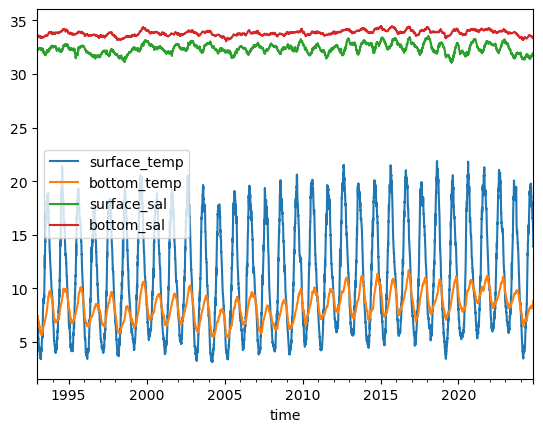

In [30]:
offshore_ts[0].plot("time")

## What Does the Entire Area Resemble?

In [31]:
# This looks so weird...
#glorys_all.thetao.mean(dim = ("longitude", "latitude")).plot()
glorys_all.time

<xarray.DataArray 'time' (time: 11618)> Size: 93kB
array(['1993-01-01T00:00:00.000000000', '1993-01-02T00:00:00.000000000',
       '1993-01-03T00:00:00.000000000', ..., '2024-10-20T00:00:00.000000000',
       '2024-10-21T00:00:00.000000000', '2024-10-22T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 93kB 1993-01-01 1993-01-02 ... 2024-10-22
Attributes:
    valid_min:  376944
    valid_max:  377664

# Save timeseries for Inspection

In [22]:
# Save Inshore Data Locally
for region_ts, region_name in zip(inshore_ts, inshore_names):
    #os.listdir("../local_data")
    region_ts.to_csv(f"../local_data/inshore_timeseries/GLORYs_surfbottempsal_{region_name}.csv")


# Save Offshore Data Locally
for region_ts, region_name in zip(offshore_ts, offshore_names):
    #os.listdir("../local_data")
    region_ts.to_csv(f"../local_data/offshore_timeseries/GLORYs_surfbottempsal_{region_name}.csv")